#Import Libraries

In [11]:
import theano
import theano.tensor as T
from theano import pp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from __future__ import division #this is important!!! otherwise, dividing will round
from collections import OrderedDict
import algopy as ap
from algopy import UTPM
%matplotlib inline

#Translate Carlos's Code to Python

In [12]:
global epsilon

In [429]:
def make_bins(B,dx):
    '''
    inputs:
    -------
    - B is the value of the accumulator's sticky bound
    - dx is the spacing between all bins, except the first and last 
    - binN is the number of bins with bin centers > 0
    
    outputs:
    --------
    - bin_centers array of bin_centers
    - binN the number of bins with positive centers 
    '''
    binN = np.ceil(B/dx)
    
    bins = np.arange(1,binN+1)*B
    bins = dx*bins/B
    bins[-1] = B + dx if bins[-1] == B else 2*B - bins[-2]
    
    bins = np.append(np.append(-bins[np.arange(-1,-1-len(bins),-1)], 0), bins)  
    
    return bins, binN
    

In [430]:
def Fmatrix(pd,bin_centers,sigma_sbin,dt):
    '''
    inputs:
    -------
    - pd ditionary of parameters expected to contain the following keys
        - sigma,
        - lam
        - c
    - bins an array of bin centers created by make_bins
    - sigma_sbin
    outputs:
    --------
    - F square Markov matrix of transition probabilities
    '''
    sigma = pd['sigma']
    lam   = pd['lam']
    c     = pd['c']

    F = np.zeros([len(bin_centers),len(bin_centers)]) 
    
    # what about when best fit lambda is 0?
    mus      = (bin_centers + pd['c']/lam)*np.exp(lam*dt) - pd['c']/lam 
    sbinsize = 0.1*np.sqrt(sigma_sbin**2 * dt)
    swidth   = 4*np.sqrt((sigma_sbin/dx)**2*dt)
    sbins    = np.arange(-swidth,swidth+epsilon, sbinsize)
    ps       = np.exp(-sbins**2 / (2*sigma**2*dt)) / np.sqrt(2*sigma**2*dt)
    ps       = ps/np.sum(ps);
    
    base_sbins = np.array(range(len(sbins)),dtype=float)*sbinsize
    
    for j in range(len(bin_centers)):
        
        sbins = base_sbins + mus[j] - swidth
        
        for k in range(len(sbins)):
            if sbins[k] < (bin_centers[0] + bin_centers[1])/2 :
                F[0,j] += ps[k]
            elif (bin_centers[-1]+bin_centers[-2])/2 <= sbins[k] :
                F[-1,j] += ps[k]
            else:
                bot = np.where(bin_centers <= sbins[k])[0][-1]
                top = bot+1
                F[bot,j] = F[bot,j] + ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bot])
                F[top,j] = F[top,j] + ps[k]*(sbins[k] - bin_centers[bot])/(bin_centers[top] - bin_centers[bot])

    F[:,0] = 0; F[:,-1] = 0; F[0,0] = 1; F[-1,-1] = 1;
    return F

In [431]:
def prob_right(pd,dt,dx,c):
    '''
    returns probability that the agent chose right
    '''
    c_trace = []; bin_centers = []; binN = []; a_trace = [];
    Nsteps = len(c)
    
    sigma_sbin = pd['sigma_a']
    sigma_a    = pd['sigma_a']*np.sqrt(dt)/dx
    sigma_s    = pd['sigma_s']
    sigma_i    = pd['sigma_i']
    bias       = pd['bias']
    B          = pd['B']
    lam        = pd['lam']
    phi        = pd['phi']
    tau_phi    = pd['tau_phi']
    lapse      = pd['lapse']
   
    bin_centers, binN = make_bins(B,dx)
    
    binBias = bias // dx + binN+1;
    
    a_trace = np.zeros([len(bin_centers), Nsteps]);  
    c_trace = np.zeros(Nsteps)

    a       = np.zeros(len(bin_centers)) 
    a[binN] = 1-2*lapse
    a[0]    = lapse
    a[-1]   = lapse
    c_eff   = 1
    
    Fi = Fmatrix({'sigma':sigma_i/dx, 'lam':lam, 'c':0}, bin_centers, sigma_sbin, dt)
    a = np.dot(Fi, a) 
    a_trace[:,0] = a
    F0  = Fmatrix({'sigma':sigma_a, 'lam':lam, 'c':0}, bin_centers, sigma_sbin, dt)
    
    for step in range(int(Nsteps)-1):
        c_eff = 1 + (c_eff - 1)*np.exp(-dt/tau_phi)
        c_trace[step] = c_eff
        if c[step]==0:
            a = np.dot(F0,a) 
        else: 
            F = Fmatrix({'sigma':sigma_a, 'lam':lam, 'c':c_eff/dt},bin_centers, sigma_sbin, dt) 
            a = np.dot(F,a) 
            c_eff = c_eff*phi
        a_trace[:,step+1] = a

    pright = np.sum(a[binBias:]) + a[binBias-1]*0.5*(dx/2 - (bias - bin_centers[binBias-1]))/(dx/2)
    return pright, a_trace, a, bin_centers

0.912446186414
2.44294128736


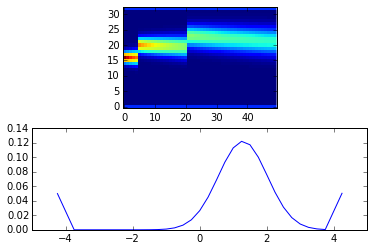

In [432]:
epsilon = 10e-10; dx =.25; dt = .02; Nsteps = np.ceil(1/dt); 
pd = {'sigma':1, 'lam':-.5, 'sigma_a':1, 'sigma_s':0, 'sigma_i':0.5, 
      'bias':0, 'B': 4,'lapse':0.05, 'tau_phi':0.2, 'phi':0.3, 'c':1.0}
sigma_sbin = pd['sigma_a']
c = np.zeros(Nsteps); c[[np.ceil(0.08/dt), np.ceil(0.4/dt)]] = 1;
pr, at, a, bin_centers = prob_right(pd,dt,dx,c)
print pr
plt.subplot(2,1,1)
plt.imshow(at,interpolation="none",origin="lower")
plt.subplot(2,1,2)
plt.plot(bin_centers,a)
mu=np.sum(bin_centers * a)
sd = np.sum(bin_centers * bin_centers * a)
sd = sd - mu ** 2
print sd

# with theano, it's not as straightforward to get a hessian, 
# perhaps it would be easier to work with algopy

#Try to make this work with Theano

In [436]:
epsilon = 10e-10; dx =.25; dt = .02; 

dx = 4; dt = .5; Nsteps = np.ceil(1/dt)

c = np.zeros(Nsteps); c[[np.ceil(0.08/dt), np.ceil(0.4/dt)]] = 1

In [437]:
c

array([ 0.,  1.])

In [419]:
epsilon = 10e-10; dx =.25; dt = .02; Nsteps = np.ceil(1/dt)

dx = 4; dt = 1; 

c = np.zeros(Nsteps); c[[np.ceil(0.08/dt), np.ceil(0.4/dt)]] = 1

lam     = theano.shared(-0.5)
phi     = theano.shared(0.3)
tau_phi = theano.shared(0.2) 
bias    = theano.shared(0.0)
lapse   = theano.shared(.05)
B       = theano.shared(4.0) 
#sigma   = theano.shared(1.0)
sigma_a = theano.shared(3.0) #sigma_a = theano.shared(1.0)
sigma_s = theano.shared(0.0)
sigma_i = theano.shared(2.0) #sigma_i = theano.shared(0.5)

sigma_sbin = sigma_a

def binN():
    #return T.ceil(B.get_value()/dx)
    return T.ceil(B/dx)

def make_bins_T():
    #bin_end = B + dx if binN() * dx == B.get_value() else 2*B - (binN() - 1) * dx
    bin_end = B + dx if binN() * dx == B else 2*B - (binN() - 1) * dx
    bins = T.concatenate([[-bin_end],T.arange(-dx,-B,-dx).sort(),[0],T.arange(dx,B,dx),[bin_end]])
    return bins

def Fmatrix_T(c,initial=False):
    bin_centers = make_bins_T()
    n_bins = T.shape(bin_centers)[0]
    
    F = T.zeros([n_bins,n_bins])
    
    mus = (bin_centers + c/lam)*T.exp(lam*dt) - c/lam
    sbinsize = 0.1*T.sqrt(sigma_sbin**2 * dt)
    swidth   = 4*T.sqrt((sigma_sbin/dx)**2*dt)
    sbins    = T.arange(-swidth,swidth+epsilon, sbinsize)
    
    ps = T.exp(-sbins**2 / (2*sigma_a**2*dt)) / T.sqrt(2*sigma_a**2*dt) if not initial else T.exp(-sbins**2 / (2*sigma_i/dx**2*dt)) / T.sqrt(2*sigma_i/dx**2*dt) 
    ps = ps/T.sum(ps)
    
    n_sbins = T.shape(sbins)[0]
    base_sbins = T.arange(0,n_sbins)*sbinsize

    for j in range(1,n_bins-1): # don't both with first and last column since we're just going to set those to zero
        print 'this j is', j+1, 'of', n_bins, '..........'
        sbins = base_sbins + mus[j] - swidth
        
        for k in range(n_sbins):
            if T.lt(sbins[k] , (bin_centers[0] + bin_centers[1])/2):
                F = T.inc_subtensor(F[0,j], ps[k].eval())
            elif T.le(bin_centers[-1] + bin_centers[-2])/2 , sbins[k]):
                F = T.inc_subtensor(F[-1,j], ps[k].eval())
            else:
                bot = T.switch(T.le(bin_centers,sbins[k]),
                               T.ones_like(bin_centers),T.zeros_like(bin_centers))[-1]
                top = bot+1 
                bot_inc = ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bot])
                top_inc = ps[k]*(sbins[k] - bin_centers[bot])/(bin_centers[top] - bin_centers[bot])                                                                    
                F = T.inc_subtensor(F[bot,j], bot_inc)
                F = T.inc_subtensor(F[top,j], top_inc)

    
    F = T.set_subtensor(F[:,0],0)
    F = T.set_subtensor(F[:,-1],0)
    F = T.set_subtensor(F[0,0],1)
    F = T.set_subtensor(F[-1,-1],1)
    return F
   
def prob_right_T():
    c_trace = []; a_trace = []; Nsteps = len(c)
    #sigma_a    = sigma_a*np.sqrt(dt)/dx
    c = T.dvector('c')
    bin_centers = make_bins_T()
    
    binBias = bias // dx + binN() + 1;

    n_bins  = T.shape(bin_centers)[0]
    a_trace = np.zeros([n_bins, Nsteps]);  
    c_trace = np.zeros(Nsteps)

    a       = T.zeros(n_bins) 
    a       = T.set_subtensor(a[int(binN().eval())], 1-2*lapse)
    a       = T.set_subtensor(a[0], lapse)
    a       = T.set_subtensor(a[-1], lapse)
    c_eff   = 1
    
    Fi = Fmatrix_T(0,initial=True)
    a = T.dot(Fi, a) 
    a_trace[:,0] = a.eval()
    F0  = Fmatrix_T(0,initial=False)
    
    for step in range(int(Nsteps)-1):
        c_eff = 1 + (c_eff - 1)*T.exp(-dt/tau_phi)
        #c_trace[step] = c_eff.eval()
        if c[step]==0:
            a = T.dot(F0,a) 
        else: 
            F = Fmatrix_T(c_eff/dt, initial=False) 
            a = T.dot(F,a) 
            c_eff = c_eff*phi
        #a_trace[:,step+1] = a.eval()
    
    #ix = int(binBias.eval())
    #pright = T.sum(a[ix:]) + a[ix-1]*0.5*(dx/2 - (bias - bin_centers[ix-1]))/(dx/2)
    #return pright, a_trace, a, bin_centers
    
    
    return T.sum(a[binBias:]) + a[binBias-1]*.5*(dx/2 - (bias - bin_centers[ix-1]))/(dx/2)

In [365]:
dx = 2; dt = .5; B=4

bin_centers, _ = make_bins(B,dx)
Fmatrix({'sigma':1.0, 'lam':-.5, 'c':1.0},bin_centers, 1.0, dt)

array([[ 1.        ,  0.00497356,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54546971,  0.04629166,  0.        ,  0.        ],
       [ 0.        ,  0.4467679 ,  0.68621746,  0.12889425,  0.        ],
       [ 0.        ,  0.00278883,  0.26749088,  0.80665863,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.06444712,  1.        ]])

In [ ]:
#actually need c to be theano tensor variable as well
c = T.vector('c')

In [420]:
o = prob_right_T(c)

[3 3]
this j is 2 of 3 ..........
1 of 21 case 3
2 of 21 case 3
3 of 21 case 3
4 of 21 case 3
5 of 21 case 3
6 of 21 case 3
7 of 21 case 3
8 of 21 case 3
9 of 21 case 3
10 of 21 case 3
11 of 21 case 3
12 of 21 case 3
13 of 21 case 3
14 of 21 case 3
15 of 21 case 3
16 of 21 case 3
17 of 21 case 3
18 of 21 case 3
19 of 21 case 3
20 of 21 case 3
21 of 21 case 3
[3 3]
this j is 2 of 3 ..........
1 of 21 case 3
2 of 21 case 3
3 of 21 case 3
4 of 21 case 3
5 of 21 case 3
6 of 21 case 3
7 of 21 case 3
8 of 21 case 3
9 of 21 case 3
10 of 21 case 3
11 of 21 case 3
12 of 21 case 3
13 of 21 case 3
14 of 21 case 3
15 of 21 case 3
16 of 21 case 3
17 of 21 case 3
18 of 21 case 3
19 of 21 case 3
20 of 21 case 3
21 of 21 case 3
[3 3]
this j is 2 of 3 ..........
1 of 21 case 3
2 of 21 case 3
3 of 21 case 3
4 of 21 case 3
5 of 21 case 3
6 of 21 case 3
7 of 21 case 3
8 of 21 case 3
9 of 21 case 3
10 of 21 case 3
11 of 21 case 3
12 of 21 case 3
13 of 21 case 3
14 of 21 case 3
15 of 21 case 3
16 of 21 case

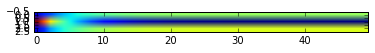

In [423]:
plt.imshow(o[1])

In [428]:
o[0].eval()

array(0.5351346541780123)

In [368]:
b=make_bins_T()

In [375]:
T.sum(b[1:]).eval()

array(6.0)

In [305]:
F = Fmatrix_T(1)


[5 5]
this j is 1 of 5 ..........
0 of 41 case 3
1 of 41 case 3
2 of 41 case 3
3 of 41 case 3
4 of 41 case 3
5 of 41 case 3
6 of 41 case 3
7 of 41 case 3
8 of 41 case 3
9 of 41 case 3
10 of 41 case 3
11 of 41 case 3
12 of 41 case 3
13 of 41 case 3
14 of 41 case 3
15 of 41 case 3
16 of 41 case 3
17 of 41 case 3
18 of 41 case 3
19 of 41 case 3
20 of 41 case 3
21 of 41 case 3
22 of 41 case 3
23 of 41 case 3
24 of 41 case 3
25 of 41 case 3
26 of 41 case 3
27 of 41 case 3
28 of 41 case 3
29 of 41 case 3
30 of 41 case 3
31 of 41 case 3
32 of 41 case 3
33 of 41 case 3
34 of 41 case 3
35 of 41 case 3
36 of 41 case 3
37 of 41 case 3
38 of 41 case 3
39 of 41 case 3
40 of 41 case 3
this j is 2 of 5 ..........
0 of 41 case 3
1 of 41 case 3
2 of 41 case 3
3 of 41 case 3
4 of 41 case 3
5 of 41 case 3
6 of 41 case 3
7 of 41 case 3
8 of 41 case 3
9 of 41 case 3
10 of 41 case 3
11 of 41 case 3
12 of 41 case 3
13 of 41 case 3
14 of 41 case 3
15 of 41 case 3
16 of 41 case 3
17 of 41 case 3
18 of 41 case 

In [365]:
F.eval()

array([[ 1.        ,  0.00497356,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54546971,  0.04629166,  0.        ,  0.        ],
       [ 0.        ,  0.4467679 ,  0.68621746,  0.12889425,  0.        ],
       [ 0.        ,  0.00278883,  0.26749088,  0.80665863,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.06444712,  1.        ]])

#Try something simple with Theano

In [10]:
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y,x)
pp(gy)

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [26]:
f = theano.function([x], gy)
pp(f.maker.fgraph.outputs[0])

'(TensorConstant{2.0} * x)'

In [28]:
[f(a) for a in [1, 5, 10, 11]]

[array(2.0), array(10.0), array(20.0), array(22.0)]

## Okay, let's try something a bit more complicated

In [82]:
x = T.dscalar('x')
s = (1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)


here's the function

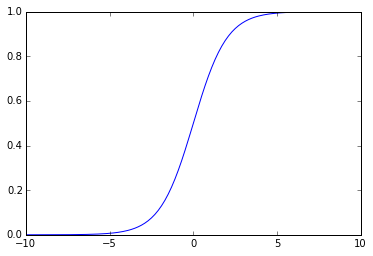

In [52]:
x = np.arange(-10,10,.1)
y = [1/(1+np.exp(-this_x)) for this_x in x]
plt.plot(x,y)

and here's its gradient

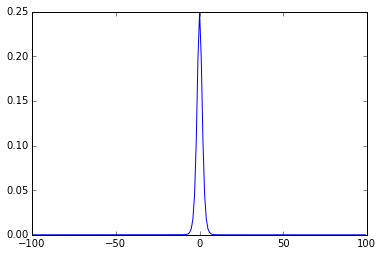

In [86]:
x_vals = np.arange(-100,100)
dsdx = [dlogistic(a).sum() for a in x_vals]
plt.plot(x_vals, dsdx)

## even more so?

In [196]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)

In [211]:
dlogistic([[1,5], [-10, -10], [0,100]])

array([[  1.96611933e-01,   6.64805667e-03],
       [  4.53958077e-05,   4.53958077e-05],
       [  2.50000000e-01,   3.72007598e-44]])

In [222]:
x0 = np.arange(100,-101,-1)
x1 = np.arange(-100,101)
x_vals = np.array([[a,b] for a in x0 for b in x1])
dsdx = dlogistic(x_vals)

derivative w.r.t x0

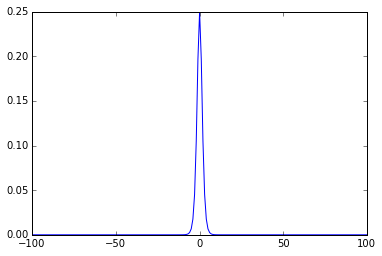

In [233]:
plt.plot(x_vals[:,0],dsdx[:,0])

derivative w.r.t x1

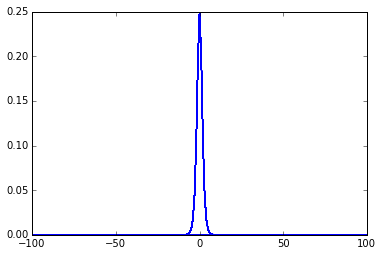

In [235]:
plt.plot(x_vals[:,1],dsdx[:,1])